In [142]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta

In [143]:
month = 'jan'
month_num = '01'

In [144]:
ds_delta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/pulse_{month}_BC/OutputDir/GEOSChem.AerosolMass.2016*', combine = 'by_coords')

In [145]:
ds_base = xr.open_mfdataset(f'../GCrundirs/IRF_runs/base_{month}_BC/OutputDir/GEOSChem.AerosolMass.2016*', combine = 'by_coords')

In [146]:
ds_emisbase = xr.open_mfdataset(f'../GCrundirs/IRF_runs/base_{month}_BC/OutputDir/HEMCO_diagnostics.2016*', combine = 'by_coords')

In [147]:
ds_emispulse = xr.open_mfdataset(f'../GCrundirs/IRF_runs/pulse_{month}_BC/OutputDir/HEMCO_diagnostics.2016*.nc', combine = 'by_coords')

In [148]:
ds_conc2x = xr.open_mfdataset('../GCrundirs/IRF_runs/2x_jan_BC/OutputDir/GEOSChem.AerosolMass.2016*.nc4', combine = 'by_coords')
ds_emis2x = xr.open_mfdataset('../GCrundirs/IRF_runs/2x_jan_BC/OutputDir/HEMCO_diagnostics.2016*', combine = 'by_coords')

In [149]:
height = pd.read_excel('gc_altitude.xlsx')

In [150]:
height_ds = height.diff().dropna().to_xarray().rename({'index':'lev'})
height_ds['lev'] = ds_base['lev']
height_ds = height_ds.rename({'altitude':'dz'}) 
height_ds['dz']*=1e3


In [151]:
ds_emisbase = xr.merge([ds_emisbase, height_ds], join = 'inner')
ds_emispulse = xr.merge([ds_emispulse, height_ds], join = 'inner')
ds_base = xr.merge([ds_base, height_ds], join = 'inner')
ds_delta = xr.merge([ds_delta, height_ds], join = 'inner')
ds_conc2x = xr.merge([ds_conc2x, height_ds], join = 'inner')
ds_emis2x = xr.merge([ds_emis2x, height_ds], join = 'inner')

In [152]:
def combine_BC(ds):
    sec_day = 86400
    ds['EmisBC_Total'] = (ds['EmisBCPI_Total'] + ds['EmisBCPO_Total'])
    ds['EmisBC_Total'].attrs = {'full_name':'total black carbon','units':'kg/m2/day'}
    ds['EmisBC_Total'] *=sec_day

In [153]:
sec_day = 86400

In [154]:
datasets = [ds_emispulse, ds_emisbase, ds_base, ds_delta, ds_conc2x, ds_emis2x]

In [155]:
for ds in [ds_emispulse, ds_emisbase,ds_emis2x]:
    combine_BC(ds)

## Recreate Doubled Concentration

In [156]:
def global_w_mean(ds, variable):
    return (ds[variable].weighted(ds['AREA']*ds['dz']).mean(dim = ['lat','lon','lev']))

In [157]:
def lev_mean(ds, variable):
    return (ds[variable].weighted(ds['AREA']*ds['dz']).mean(dim = ['lev']))

In [158]:
f = (global_w_mean(ds_emis2x, 'EmisBC_Total') - global_w_mean(ds_emisbase, 'EmisBC_Total'))
f= f.assign_coords(time = np.arange(0,len(f['time']))) #inputting a x2 until we get our doubled emissions as daily data
G = (lev_mean(ds_delta, 'AerMassBC') - 
     lev_mean(ds_base, 'AerMassBC'))
G = G.assign_coords(time = np.arange(0,len(G['time'])))

f0 = (global_w_mean(ds_emispulse, 'EmisBC_Total') - 
      global_w_mean(ds_emisbase, 'EmisBC_Total')).isel(time = 0)

```python
f = [1,2,3]
G = [1, 0.5, 0.25, 0.01]

plt.plot([t[0], t[1], t[2]], [f[0]*G[i].values*dt for i in [0, 1, 2]])
plt.plot([t[0], t[1], t[2]], [f[0]*G[i+1].values*dt for i in [0, 1, 2]] + [f[1]*G[i].values*dt for i in [0, 1, 2]])  
```

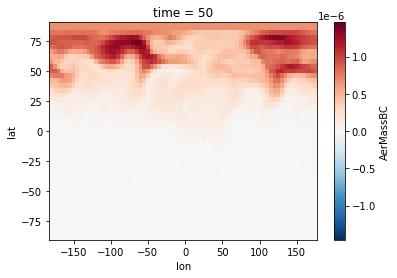

In [159]:
G.isel(time = 50).plot()

In [160]:
f0.values

array(3.09279411e-11)

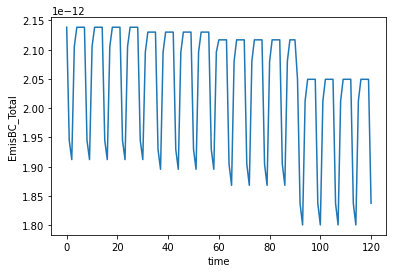

In [161]:
f.plot()

In [162]:
def f_(raw_f, t_p): 
    return raw_f.interp({'time':t_p})

In [193]:
def G_(GC_out, t, t_p, f_0, Δt):
    'where G(t-t_p) such that t-t_p = s), if s<0, the function goes to 0'
    s = t-t_p
    if t>t_p:
        G = GC_out.interp({'time':s})/(Δt*f_0) #divide by our original f0 and our dt in order to get into units of concentration
    elif t_p>=t:
        G = xr.zeros_like(GC_out.interp({'time':s})) #np.nan
        
    return(G)

In [194]:
def G_f_kernel(raw_G, raw_f, t, t_p, Δt, dt, f_0):
    'where C(t) = int[G(t-t_p)f(t_p)]dt and t_p is the midpoint of the integral (eg: if integrating from 2020-2030, it is dt/2 away from 2020)'
    return(G_(raw_G, t, t_p, f_0, Δt)*f_(raw_f, t_p)*dt)


In [195]:
Ndt = 30
dt = 1 #days
t_range = np.arange(0., dt*Ndt, dt)
Δt = 1


In [196]:
C_ds = xr.Dataset(
    data_vars = dict(c = (["time","lat","lon","i"], np.zeros([len(f['time']),len(ds_base['lat']),len(ds_base['lon']),len(t_range)]))),
    coords = dict(
        time = f['time'],
        lat = ("lat", ds_base['lat']),
        lon = ("lon", ds_base['lon']),
        i = t_range
    )

)

In [233]:
C_df

c                                                                    \
time  0         1             2             3             4             5     
i                                                                             
0.0   0.0 -0.000004  9.948836e-07  1.307636e-04  2.083404e-04  8.113848e-05   
1.0   0.0  0.000000 -3.580992e-06  9.049608e-07  1.189445e-04  1.895095e-04   
2.0   0.0  0.000000  0.000000e+00 -3.520334e-06  8.896317e-07  1.169297e-04   
3.0   0.0  0.000000  0.000000e+00  0.000000e+00 -3.876165e-06  9.795545e-07   
4.0   0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00 -3.936823e-06   
5.0   0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
6.0   0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
7.0   0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
8.0   0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9.0   0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
10.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
11.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
12.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
13.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
14.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
15.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
16.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
17.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
18.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
19.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
20.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
21.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
22.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
23.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
24.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
26.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
27.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
28.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
29.0  0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                                                              ...            \
time           6             7             8             9    ...  111  112   
i                                                             ...             
0.0   1.364471e-04  6.171118e-05  3.902687e-06  7.412542e-06  ...  0.0  0.0   
1.0   7.380476e-05  1.241143e-04  5.613340e-05  3.549942e-06  ...  0.0  0.0   
2.0   1.862994e-04  7.255459e-05  1.220119e-04  5.518256e-05  ...  0.0  0.0   
3.0   1.287488e-04  2.051303e-04  7.988831e-05  1.343447e-04  ...  0.0  0.0   
4.0   9.948836e-07  1.307636e-04  2.083404e-04  8.113848e-05  ...  0.0  0.0   
5.0  -3.936823e-06  9.948836e-07  1.307636e-04  2.083404e-04  ...  0.0  0.0   
6.0   0.000000e+00 -3.936823e-06  9.948836e-07  1.307636e-04  ...  0.0  0.0   
7.0   0.000000e+00  0.000000e+00 -3.936823e-06  9.948836e-07  ...  0.0  0.0   
8.0   0.000000e+00  0.000000e+00  0.000000e+00 -3.580992e-06  ...  0.0  0.0   
9.0   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.0  0.0   
10.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.0  0.0   
11.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.0  0.0   
12.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.0  0.0   
13.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.0  0.0   
14.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e

<AxesSubplot:xlabel='None,time'>

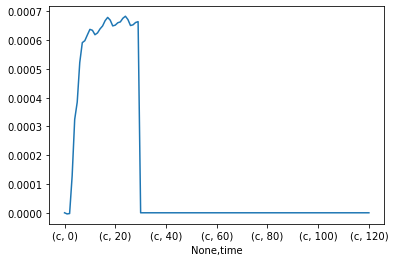

In [235]:
C_df.sum(axis = 0).plot()

In [228]:
C_df = C_ds.sel(lat = 50, lon = -100, method = 'nearest').drop(['lat','lon']).to_dataframe().unstack()

In [201]:
for i, tp in enumerate(t_range):
    for t in t_range:
        i = int(i)
        C_ds['c'].loc[dict(i = i, time = t)] = G_f_kernel(G, f, t, tp,Δt, dt, f0)
        


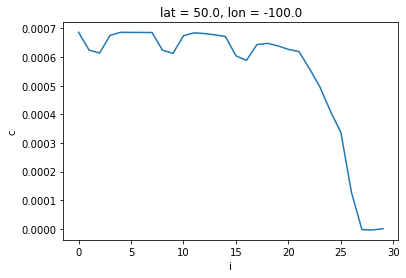

In [204]:
C_ds.sum(dim = 'time').sel(lat = 50, lon = -100, method = 'nearest')['c'].plot()

In [123]:
(C_ds.sum(dim = 'i').isel(time = 30) - C_ds.sum(dim = 'i').isel(time = 0))['c'].values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Text(0.5, 1.0, 'GEOS Chem 2x')

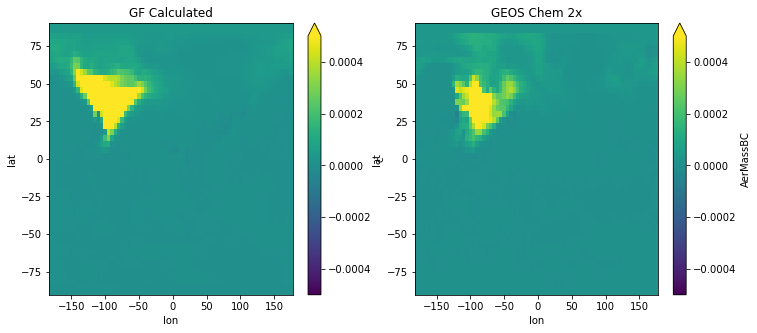

In [218]:
t = 20

fig, axes = plt.subplots(ncols = 2, figsize = [12,5])
vmin = -.0005
vmax = .0005
C_ds.sum(dim = 'i').isel(time = t)['c'].plot(ax = axes[0],
                                            vmin = vmin,
                                            vmax = vmax)
axes[0].set_title('GF Calculated')
(lev_mean(ds_conc2x, 'AerMassBC')-
 lev_mean(ds_base, 'AerMassBC')).assign_coords(time = np.arange(0,len(ds_base['time']))).isel(time = t).plot(
    ax = axes[1],
    vmin = vmin,
    vmax = vmax)
axes[1].set_title('GEOS Chem 2x')


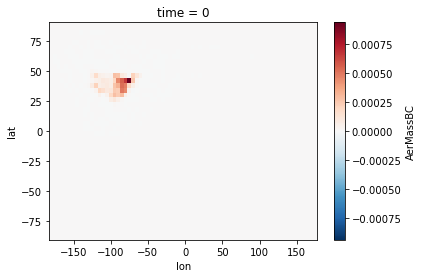

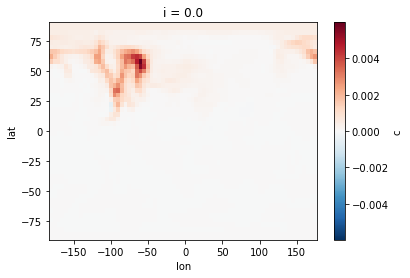

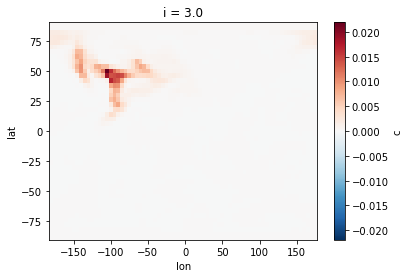

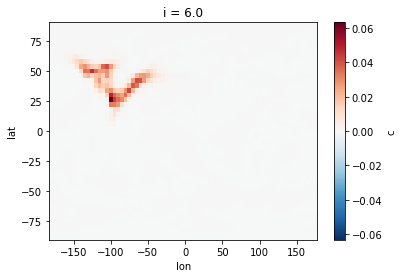

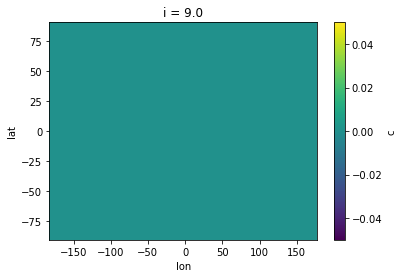

In [78]:
for t in [0,3,6,9]:
    fig, ax = plt.subplots()
    C_ds['c'].sum(dim = 'time').isel(i = t).plot(ax = ax)

ValueError: setting an array element with a sequence.

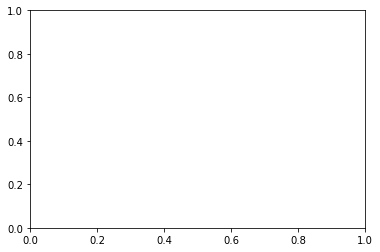

In [39]:
plt.plot(C_df.sum(axis = 1));

#plt.ylim(0,1.2e-9)

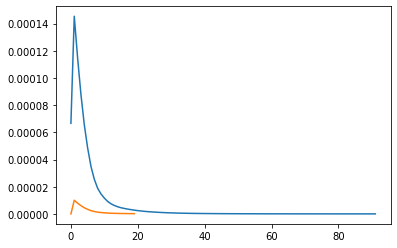

In [39]:
plt.plot(G);
plt.plot(C_df[0])

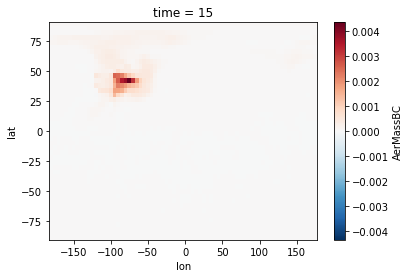

In [49]:
(lev_mean(ds_conc2x, 'AerMassBC') - lev_mean(ds_base, 'AerMassBC')).assign_coords(time = np.arange(0,len(ds_base['time']))).isel(time = 15).plot()
#((C_df.sum(axis = 1)).to_xarray().rename({'index':'time'})).plot(marker = 'o')
#plt.plot(C_df.sum(axis = 1));
